# Surrogate Model Training & Token-Level Attribution

This notebook demonstrates how to train an **interpretable surrogate model** on GPT-4o–generated sentiment labels and use **SHAP** for token-level attribution.


## 1. Surrogate Model Training

**Why a surrogate?**  
- Approximates the LLM’s decision boundary in an interpretable form.

**Steps:**  
1. Load GPT-4o sentiment labels from `dataset_67.json`.  
2. Use TF-IDF to vectorize transcript chunks.  
3. Train a Logistic Regression classifier on these labels.


In [82]:
import json
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd

nltk.download('punkt')

# Load dataset
with open('dataset_67.json') as f:
    data = json.load(f)

# Map sentiments to numeric labels
label_map = dict(zip(pd.DataFrame(data)['sentiment'].apply(lambda x: x.lower()).unique(),range(len(pd.DataFrame(data)['sentiment'].unique()))))

# Chunking function
def chunk_text(text, chunk_size=200, overlap=50):
    tokens = word_tokenize(text)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + chunk_size, len(tokens))
        chunks.append(' '.join(tokens[start:end]))
        if end == len(tokens):
            break
        start += chunk_size - overlap
    return chunks

# Prepare DataFrame of chunks
rows = []
for entry in data:
    sentiment = entry.get('sentiment', 'neutral').lower()
    label = label_map.get(sentiment, 1)
    transcript = entry.get('summary', '')  # use summary as proxy
    for chunk in chunk_text(transcript):
        rows.append({'chunk': chunk, 'label': label})

df_chunks = pd.DataFrame(rows*5)
print(f"Total chunks: {len(df_chunks)}")
df_chunks.head()

Total chunks: 335


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,chunk,label
0,The call involves a brief exchange where one p...,0
1,The call involves a discussion about a laptop ...,0
2,The call involves a request for the customer t...,0
3,The call discusses the setup and configuration...,0
4,The call involves a customer service interacti...,0


### Vectorize and Random Forest Classification.

In [83]:
import pandas as pd
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Balance the dataframe: downsample each label to the size of the smallest class
min_count = df_chunks['label'].value_counts().min()
balanced_df = pd.concat([
    df_chunks[df_chunks['label']==label].sample(n=min_count, random_state=42)
    for label in df_chunks['label'].unique()
])

# Optional: Shuffle the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['chunk'], balanced_df['label'], test_size=0.5, random_state=42, stratify=balanced_df['label']
)

# 3. Vectorize
tfidf = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 4. Convert sparse matrix to dense format (required by RandomForest)
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# 5. Train Random Forest classifier
surrogate = RandomForestClassifier(n_estimators=100, random_state=42)
surrogate.fit(X_train_dense, y_train)

# 6. Evaluate
print("Training complete.")
print("Test accuracy:", surrogate.score(X_test_dense, y_test))

Training complete.
Test accuracy: 0.9333333333333333


## 2. Token-Level Attribution with SHAP

For each transcript chunk, SHAP computes a contribution score per token:

- **Positive scores** push the prediction toward a class (e.g., 'angry' tokens → negative sentiment).
- **Negative scores** pull the prediction away from that class.


In [84]:
surrogate.predict_proba(X_train_tfidf).argmax(axis=-1)

array([0, 1, 1, 5, 5, 2, 2, 1, 0, 3, 5, 4, 0, 3, 4])

In [85]:
y_train.value_counts()

label
0    3
1    3
5    3
2    2
3    2
4    2
Name: count, dtype: int64

In [86]:
label_map

{'neutral': 0,
 'frustrated': 1,
 'incomprehensible': 2,
 'inquisitive': 3,
 'frustrated but cooperative': 4,
 'confused': 5}

<Figure size 640x480 with 0 Axes>

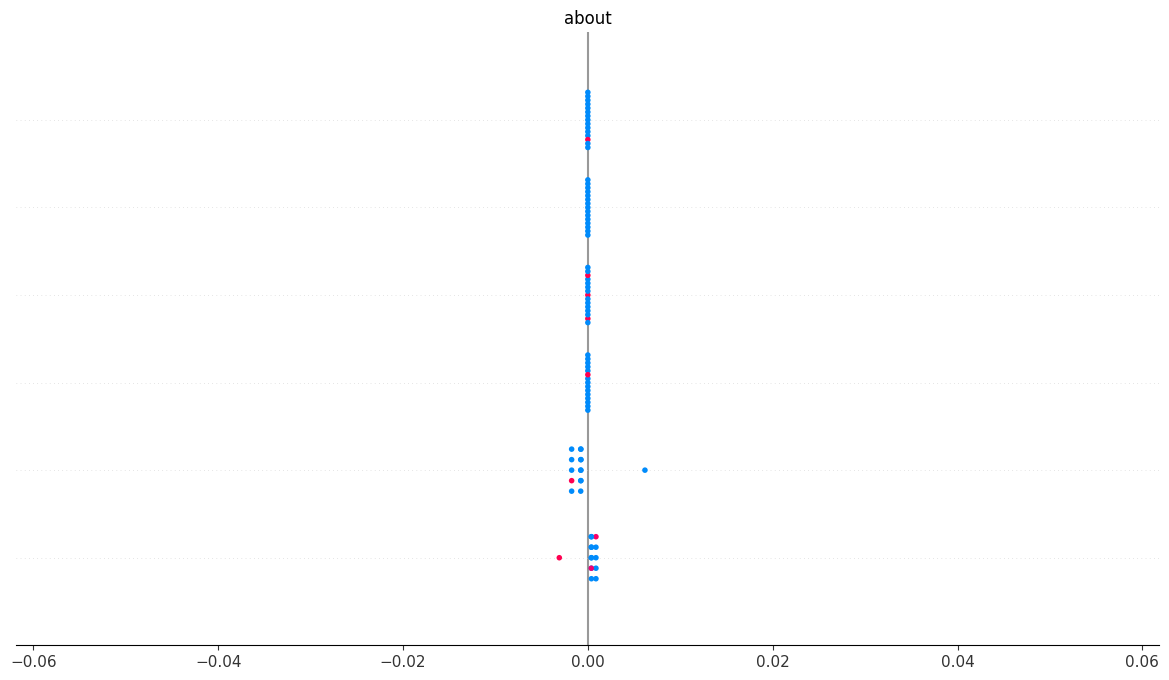

In [87]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Convert sparse TF-IDF to dense float32 array
X_test_dense = X_test_tfidf[:30].toarray().astype(np.float32)

# Initialize SHAP explainer for tree-based models
explainer = shap.TreeExplainer(surrogate)

# Get SHAP values
shap_values = explainer.shap_values(X_test_dense)

# Get feature (phrase) names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)

## 3. Aggregating Shapley Values

1. The surrogate model embeds each transcript chunk.  
2. `shap.TreeExplainer` samples coalitions of tokens.  
3. Aggregated Shapley values highlight key phrases influencing sentiment predictions.  


In [88]:
import pandas as pd

# Choose the class index (e.g., 1 for a binary classifier). If classifier is binary, shap_values is a list with two elements.
class_index = 1 if isinstance(shap_values, list) else 0

# Show top SHAP values per sample
for i in range(5):  # Show top phrases for 5 test samples
    print(f"\nSample {list(label_map.keys())[i]}:")
    shap_array = shap_values[class_index][i]  # Shape: (n_features,)
    
    # Pair feature names with their SHAP values
    shap_dict = dict(zip(feature_names, shap_array))

    # Sort to get most impactful phrases
    top_phrases = sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    
    for phrase, val in top_phrases:
        print(f"  {phrase}: {val:.4f}")


Sample neutral:
  about: 0.0009
  addressing: -0.0009
  adjustments: 0.0000
  advice: 0.0000
  advised: 0.0000
  also: 0.0000

Sample frustrated:
  about: 0.0000
  addressing: 0.0000
  adjustments: 0.0000
  advice: 0.0000
  advised: 0.0000
  also: 0.0000

Sample incomprehensible:
  about: 0.0000
  addressing: 0.0000
  adjustments: 0.0000
  advice: 0.0000
  advised: 0.0000
  also: 0.0000

Sample inquisitive:
  advice: -0.0102
  addressing: 0.0040
  about: 0.0030
  adjustments: 0.0020
  also: 0.0007
  advised: 0.0005

Sample frustrated but cooperative:
  addressing: -0.0010
  adjustments: 0.0007
  about: 0.0004
  advice: 0.0000
  advised: 0.0000
  also: 0.0000
